In [1]:
import requests
import pandas as pd
import numpy as np

# Season Numbers

In [2]:
url = 'https://fantasy.premierleague.com/api/bootstrap-static/'


In [3]:
r = requests.get(url)

In [4]:
json = r.json()

In [5]:
json.keys()

dict_keys(['events', 'game_settings', 'phases', 'teams', 'total_players', 'elements', 'element_stats', 'element_types'])

In [6]:
elements_df = pd.DataFrame(json['elements'])
elements_types_df = pd.DataFrame(json['element_types'])
teams_df = pd.DataFrame(json['teams'])

In [7]:
elements_df.head()

,chance_of_playing_next_round,chance_of_playing_this_round,code,cost_change_event,cost_change_event_fall,cost_change_start,cost_change_start_fall,dreamteam_count,element_type,ep_next,...,threat_rank,threat_rank_type,ict_index_rank,ict_index_rank_type,corners_and_indirect_freekicks_order,corners_and_indirect_freekicks_text,direct_freekicks_order,direct_freekicks_text,penalties_order,penalties_text
0,0.0,0.0,37605,0,0,-3,3,0,3,0.0,...,648,261,648,261,NaN,,NaN,,NaN,
1,0.0,0.0,39476,0,0,-2,2,0,2,0.0,...,586,216,607,220,NaN,,NaN,,NaN,
2,100.0,100.0,41270,0,0,-1,1,0,2,4.3,...,208,55,286,98,NaN,,4.0,,NaN,
3,0.0,50.0,54694,0,0,-7,7,1,3,0.0,...,26,14,39,25,NaN,,NaN,,1.0,
4,100.0,100.0,58822,0,0,-4,4,0,2,4.3,...,372,140,348,124,NaN,,NaN,,NaN,


In [8]:
elements_df.columns

Index(['chance_of_playing_next_round', 'chance_of_playing_this_round', 'code',
       'cost_change_event', 'cost_change_event_fall', 'cost_change_start',
       'cost_change_start_fall', 'dreamteam_count', 'element_type', 'ep_next',
       'ep_this', 'event_points', 'first_name', 'form', 'id', 'in_dreamteam',
       'news', 'news_added', 'now_cost', 'photo', 'points_per_game',
       'second_name', 'selected_by_percent', 'special', 'squad_number',
       'status', 'team', 'team_code', 'total_points', 'transfers_in',
       'transfers_in_event', 'transfers_out', 'transfers_out_event',
       'value_form', 'value_season', 'web_name', 'minutes', 'goals_scored',
       'assists', 'clean_sheets', 'goals_conceded', 'own_goals',
       'penalties_saved', 'penalties_missed', 'yellow_cards', 'red_cards',
       'saves', 'bonus', 'bps', 'influence', 'creativity', 'threat',
       'ict_index', 'influence_rank', 'influence_rank_type', 'creativity_rank',
       'creativity_rank_type', 'threat_rank'

In [39]:
elements_df[['web_name','id']]

,web_name,id
0,Özil,1
1,Sokratis,2
2,David Luiz,3
3,Aubameyang,4
4,Cédric,5
...,...,...
643,Marques,616
644,Söndergaard,617
645,Cutrone,626
646,Lonwijk,629


In [9]:
slim_elements_df = elements_df[['web_name','team','element_type','selected_by_percent','now_cost','minutes','goals_scored','assists','bps','clean_sheets','transfers_in','transfers_out','transfers_in_event','transfers_out_event','value_season','value_form','form','total_points','direct_freekicks_order','penalties_order']]



In [10]:
slim_elements_df.head()

,web_name,team,element_type,selected_by_percent,now_cost,minutes,goals_scored,assists,bps,clean_sheets,transfers_in,transfers_out,transfers_in_event,transfers_out_event,value_season,value_form,form,total_points,direct_freekicks_order,penalties_order
0,Özil,1,3,0.5,67,0,0,0,0,0,3441,53815,0,41,0.0,0.0,0.0,0,NaN,NaN
1,Sokratis,1,2,0.1,48,0,0,0,0,0,10266,18972,0,4,0.0,0.0,0.0,0,NaN,NaN
2,David Luiz,1,2,0.8,54,839,0,0,143,3,45910,94358,1357,260,5.2,0.7,3.8,28,4.0,NaN
3,Aubameyang,1,3,6.6,113,1514,5,1,202,7,561359,3253241,332,4614,6.3,0.4,4.2,71,NaN,1.0
4,Cédric,1,2,0.2,46,275,0,1,71,2,10329,36885,1342,183,4.3,0.8,3.8,20,NaN,NaN


In [11]:
slim_elements_df['position'] = slim_elements_df.element_type.map(elements_types_df.set_index('id').singular_name)

/Users/tryggvis/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [12]:
slim_elements_df.head()

,web_name,team,element_type,selected_by_percent,now_cost,minutes,goals_scored,assists,bps,clean_sheets,...,transfers_out,transfers_in_event,transfers_out_event,value_season,value_form,form,total_points,direct_freekicks_order,penalties_order,position
0,Özil,1,3,0.5,67,0,0,0,0,0,...,53815,0,41,0.0,0.0,0.0,0,NaN,NaN,Midfielder
1,Sokratis,1,2,0.1,48,0,0,0,0,0,...,18972,0,4,0.0,0.0,0.0,0,NaN,NaN,Defender
2,David Luiz,1,2,0.8,54,839,0,0,143,3,...,94358,1357,260,5.2,0.7,3.8,28,4.0,NaN,Defender
3,Aubameyang,1,3,6.6,113,1514,5,1,202,7,...,3253241,332,4614,6.3,0.4,4.2,71,NaN,1.0,Midfielder
4,Cédric,1,2,0.2,46,275,0,1,71,2,...,36885,1342,183,4.3,0.8,3.8,20,NaN,NaN,Defender


In [13]:
slim_elements_df['team'] = slim_elements_df.team.map(teams_df.set_index('id').name)

/Users/tryggvis/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [14]:
slim_elements_df.head()

,web_name,team,element_type,selected_by_percent,now_cost,minutes,goals_scored,assists,bps,clean_sheets,...,transfers_out,transfers_in_event,transfers_out_event,value_season,value_form,form,total_points,direct_freekicks_order,penalties_order,position
0,Özil,Arsenal,3,0.5,67,0,0,0,0,0,...,53815,0,41,0.0,0.0,0.0,0,NaN,NaN,Midfielder
1,Sokratis,Arsenal,2,0.1,48,0,0,0,0,0,...,18972,0,4,0.0,0.0,0.0,0,NaN,NaN,Defender
2,David Luiz,Arsenal,2,0.8,54,839,0,0,143,3,...,94358,1357,260,5.2,0.7,3.8,28,4.0,NaN,Defender
3,Aubameyang,Arsenal,3,6.6,113,1514,5,1,202,7,...,3253241,332,4614,6.3,0.4,4.2,71,NaN,1.0,Midfielder
4,Cédric,Arsenal,2,0.2,46,275,0,1,71,2,...,36885,1342,183,4.3,0.8,3.8,20,NaN,NaN,Defender


In [15]:
slim_elements_df['value'] = slim_elements_df.value_season.astype(float)

/Users/tryggvis/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [16]:
slim_elements_df.head()

,web_name,team,element_type,selected_by_percent,now_cost,minutes,goals_scored,assists,bps,clean_sheets,...,transfers_in_event,transfers_out_event,value_season,value_form,form,total_points,direct_freekicks_order,penalties_order,position,value
0,Özil,Arsenal,3,0.5,67,0,0,0,0,0,...,0,41,0.0,0.0,0.0,0,NaN,NaN,Midfielder,0.0
1,Sokratis,Arsenal,2,0.1,48,0,0,0,0,0,...,0,4,0.0,0.0,0.0,0,NaN,NaN,Defender,0.0
2,David Luiz,Arsenal,2,0.8,54,839,0,0,143,3,...,1357,260,5.2,0.7,3.8,28,4.0,NaN,Defender,5.2
3,Aubameyang,Arsenal,3,6.6,113,1514,5,1,202,7,...,332,4614,6.3,0.4,4.2,71,NaN,1.0,Midfielder,6.3
4,Cédric,Arsenal,2,0.2,46,275,0,1,71,2,...,1342,183,4.3,0.8,3.8,20,NaN,NaN,Defender,4.3


In [17]:
slim_elements_df = slim_elements_df.drop(["element_type","value_season"],axis=1)

In [18]:
slim_elements_df.sort_values('value',ascending=False).head(10)

,web_name,team,selected_by_percent,now_cost,minutes,goals_scored,assists,bps,clean_sheets,transfers_in,transfers_out,transfers_in_event,transfers_out_event,value_form,form,total_points,direct_freekicks_order,penalties_order,position,value
35,Martínez,Aston Villa,33.0,51,1710,0,0,444,10,2962346,1081422,23880,4880,1.0,5.0,103,NaN,NaN,Goalkeeper,20.2
600,Soucek,West Ham,18.4,53,1890,7,1,333,7,2022922,963037,29794,14757,0.9,5.0,97,NaN,NaN,Midfielder,18.3
120,Pope,Burnley,11.0,54,1710,0,0,418,7,489583,822583,5170,5215,0.9,4.6,98,NaN,NaN,Goalkeeper,18.1
50,Targett,Aston Villa,6.8,47,1694,0,3,385,11,804414,362507,30765,3347,1.5,7.0,84,6.0,NaN,Defender,17.9
7,Leno,Arsenal,9.2,50,1890,0,0,407,8,782679,736622,9058,2951,1.2,5.8,89,NaN,NaN,Goalkeeper,17.8
296,Bamford,Leeds,47.2,66,1695,11,7,388,6,5530263,2599604,57239,33408,0.6,4.2,116,NaN,1.0,Forward,17.6
587,Cresswell,West Ham,20.6,55,1890,0,8,453,7,2135056,699940,49148,5307,0.9,4.8,96,1.0,NaN,Defender,17.5
294,Dallas,Leeds,13.1,48,1790,4,2,389,6,1516755,851446,17354,8042,0.6,3.0,82,NaN,NaN,Defender,17.1
497,Bednarek,Southampton,12.5,49,1710,1,1,397,8,1310811,578518,6710,15413,0.6,2.8,83,NaN,NaN,Defender,16.9
448,Wilson,Newcastle,19.8,66,1687,10,5,345,5,3477702,2709909,159734,4792,0.7,4.3,110,NaN,1.0,Forward,16.7


In [19]:
slim_elements_df.pivot_table(index='position',values='value',aggfunc=np.mean).reset_index()

,position,value
0,Defender,5.031140
1,Forward,4.316471
2,Goalkeeper,4.136486
3,Midfielder,4.730651


In [20]:
pivot=slim_elements_df.pivot_table(index='position',values='value',aggfunc=np.mean).reset_index()
pivot.sort_values('value',ascending=False)

,position,value
0,Defender,5.031140
3,Midfielder,4.730651
1,Forward,4.316471
2,Goalkeeper,4.136486


In [21]:
slim_elements_df = slim_elements_df.loc[slim_elements_df.minutes > 200]
slim_elements_df = slim_elements_df.loc[slim_elements_df.value > 0]

In [22]:
pivot = slim_elements_df.pivot_table(index='position',values='value',aggfunc=np.mean).reset_index()
pivot.sort_values('value',ascending=False)

,position,value
2,Goalkeeper,12.939130
1,Forward,7.802222
0,Defender,7.708904
3,Midfielder,7.071930


In [23]:
team_pivot = slim_elements_df.pivot_table(index='team',values='value',aggfunc=np.mean).reset_index()
team_pivot.sort_values('value',ascending=False)

,team,value
1,Aston Villa,11.606667
15,Southampton,10.162500
8,Leeds,9.411111
18,West Ham,9.231579
11,Man City,8.852632
19,Wolves,8.458824
2,Brighton,8.000000
9,Leicester,7.850000
4,Chelsea,7.828571
0,Arsenal,7.508696


In [24]:
fwd_df = slim_elements_df.loc[slim_elements_df.position == 'Forward']
mid_df = slim_elements_df.loc[slim_elements_df.position == 'Midfielder']
def_df = slim_elements_df.loc[slim_elements_df.position == 'Defender']
goal_df = slim_elements_df.loc[slim_elements_df.position == 'Goalkeeper']

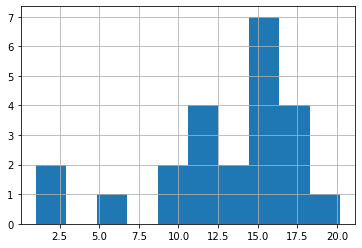

In [25]:
goal_df.value.hist()

In [26]:
goal_df.sort_values('value',ascending=False).head(10)

,web_name,team,selected_by_percent,now_cost,minutes,goals_scored,assists,bps,clean_sheets,transfers_in,transfers_out,transfers_in_event,transfers_out_event,value_form,form,total_points,direct_freekicks_order,penalties_order,position,value
35,Martínez,Aston Villa,33.0,51,1710,0,0,444,10,2962346,1081422,23880,4880,1.0,5.0,103,NaN,NaN,Goalkeeper,20.2
120,Pope,Burnley,11.0,54,1710,0,0,418,7,489583,822583,5170,5215,0.9,4.6,98,NaN,NaN,Goalkeeper,18.1
7,Leno,Arsenal,9.2,50,1890,0,0,407,8,782679,736622,9058,2951,1.2,5.8,89,NaN,NaN,Goalkeeper,17.8
485,McCarthy,Southampton,18.7,46,1710,0,0,355,7,1226785,1371017,3648,10837,0.3,1.2,76,NaN,NaN,Goalkeeper,16.5
307,Meslier,Leeds,5.7,47,1710,0,0,420,6,719152,415727,1470,3743,0.5,2.2,77,NaN,NaN,Goalkeeper,16.4
583,Fabianski,West Ham,3.8,51,1800,0,0,370,6,473604,361530,1416,2959,0.5,2.5,81,NaN,NaN,Goalkeeper,15.9
250,Areola,Fulham,3.3,45,1710,0,0,354,4,299984,174001,2730,4184,0.8,3.8,69,NaN,NaN,Goalkeeper,15.3
259,Schmeichel,Leicester,10.2,55,1890,0,0,379,7,478451,741445,4863,4307,0.8,4.6,84,NaN,NaN,Goalkeeper,15.3
166,Guaita,Crystal Palace,3.2,48,1890,0,0,366,4,431327,421577,3255,1407,1.1,5.4,72,NaN,NaN,Goalkeeper,15.0
425,Darlow,Newcastle,2.0,50,1890,0,0,397,4,334598,246961,1140,1452,0.5,2.3,74,NaN,NaN,Goalkeeper,14.8


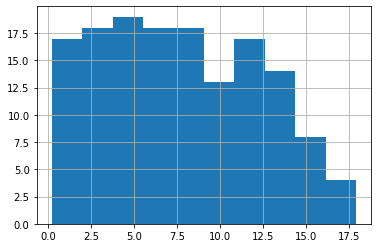

In [27]:
def_df.value.hist()

In [28]:
def_df.sort_values('value',ascending=False).head(10)

,web_name,team,selected_by_percent,now_cost,minutes,goals_scored,assists,bps,clean_sheets,transfers_in,transfers_out,transfers_in_event,transfers_out_event,value_form,form,total_points,direct_freekicks_order,penalties_order,position,value
50,Targett,Aston Villa,6.8,47,1694,0,3,385,11,804414,362507,30765,3347,1.5,7.0,84,6.0,NaN,Defender,17.9
587,Cresswell,West Ham,20.6,55,1890,0,8,453,7,2135056,699940,49148,5307,0.9,4.8,96,1.0,NaN,Defender,17.5
294,Dallas,Leeds,13.1,48,1790,4,2,389,6,1516755,851446,17354,8042,0.6,3.0,82,NaN,NaN,Defender,17.1
497,Bednarek,Southampton,12.5,49,1710,1,1,397,8,1310811,578518,6710,15413,0.6,2.8,83,NaN,NaN,Defender,16.9
280,Justin,Leicester,26.7,50,1890,1,2,381,7,2525680,1409334,21111,10428,0.7,3.4,77,NaN,NaN,Defender,15.4
377,Dias,Man City,17.5,60,1599,0,1,401,12,1643965,335385,81345,3451,1.1,6.8,91,NaN,NaN,Defender,15.2
14,Holding,Arsenal,5.3,45,1575,0,1,343,8,676594,388900,24502,2561,1.4,6.4,68,NaN,NaN,Defender,15.1
584,Ogbonna,West Ham,2.9,50,1862,2,0,341,7,364971,190803,1823,3507,0.4,2.2,75,NaN,NaN,Defender,15.0
54,Konsa,Aston Villa,5.2,46,1485,2,0,295,7,1070438,789334,2563,2934,0.9,4.0,69,NaN,NaN,Defender,15.0
496,Walker-Peters,Southampton,8.5,47,1620,0,2,354,8,1105021,1290562,99,50708,0.4,1.8,70,NaN,NaN,Defender,14.9


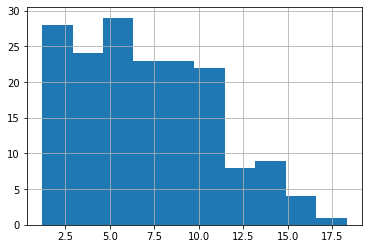

In [29]:
mid_df.value.hist()

In [30]:
mid_df.sort_values('value',ascending=False).head(10)

,web_name,team,selected_by_percent,now_cost,minutes,goals_scored,assists,bps,clean_sheets,transfers_in,transfers_out,transfers_in_event,transfers_out_event,value_form,form,total_points,direct_freekicks_order,penalties_order,position,value
600,Soucek,West Ham,18.4,53,1890,7,1,333,7,2022922,963037,29794,14757,0.9,5.0,97,NaN,NaN,Midfielder,18.3
45,Grealish,Aston Villa,38.3,77,1707,6,11,457,10,4868195,2879314,57318,12431,0.7,5.5,119,4.0,2.0,Midfielder,15.5
297,Harrison,Leeds,2.0,54,1579,5,4,286,6,511784,460050,3755,2687,0.8,4.5,83,3.0,NaN,Midfielder,15.4
628,Neto,Wolves,8.5,58,1711,4,5,351,6,1835349,1276870,2319,31637,0.4,2.6,88,4.0,NaN,Midfielder,15.2
22,Saka,Arsenal,11.4,54,1503,5,3,285,6,1236646,879534,10078,47230,1.2,6.6,81,6.0,NaN,Midfielder,15.0
523,Son,Spurs,59.7,98,1706,12,6,458,8,6290122,4054878,22941,27675,0.5,4.8,143,6.0,2.0,Midfielder,14.6
355,Gündogan,Man City,18.4,58,1125,7,0,320,9,1560942,159576,37447,15356,1.3,7.8,83,4.0,2.0,Midfielder,14.3
492,Ward-Prowse,Southampton,9.2,61,1800,4,5,412,8,1991372,1647219,2738,20296,0.6,3.5,87,1.0,2.0,Midfielder,14.3
179,Zaha,Crystal Palace,14.9,72,1610,9,3,250,4,3828725,3603881,19618,14585,0.4,3.0,101,NaN,3.0,Midfielder,14.0
597,Bowen,West Ham,2.6,62,1620,5,3,265,6,684744,635042,1241,3933,0.7,4.2,85,NaN,NaN,Midfielder,13.7


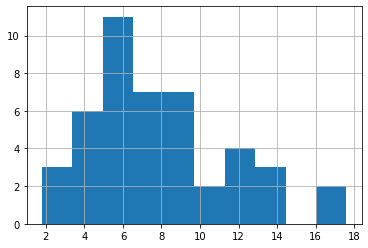

In [31]:
fwd_df.value.hist()

In [32]:
fwd_df.sort_values('value',ascending=False).head(10)

,web_name,team,selected_by_percent,now_cost,minutes,goals_scored,assists,bps,clean_sheets,transfers_in,transfers_out,transfers_in_event,transfers_out_event,value_form,form,total_points,direct_freekicks_order,penalties_order,position,value
296,Bamford,Leeds,47.2,66,1695,11,7,388,6,5530263,2599604,57239,33408,0.6,4.2,116,NaN,1.0,Forward,17.6
448,Wilson,Newcastle,19.8,66,1687,10,5,345,5,3477702,2709909,159734,4792,0.7,4.3,110,NaN,1.0,Forward,16.7
63,Watkins,Aston Villa,17.0,62,1710,8,4,273,10,2353467,1169098,53230,15692,0.6,4.0,85,NaN,3.0,Forward,13.7
209,Calvert-Lewin,Everton,38.6,76,1583,11,4,346,5,6197353,4386180,54076,40568,0.2,1.3,99,NaN,NaN,Forward,13.0
521,Kane,Spurs,27.1,111,1654,12,11,512,6,4478760,3854475,1609,317863,0.5,6.0,143,1.0,1.0,Forward,12.9
498,Adams,Southampton,5.1,59,1532,4,5,241,6,1201869,1155881,4849,13530,0.2,1.2,75,NaN,NaN,Forward,12.7
80,Maupay,Brighton,3.1,61,1386,7,1,233,5,822590,771433,4368,5706,0.7,4.0,72,NaN,2.0,Forward,11.8
266,Vardy,Leicester,14.3,100,1476,11,8,412,6,3387523,3936337,4648,37303,0.2,1.8,116,NaN,1.0,Forward,11.6
455,McGoldrick,Sheffield Utd,2.1,52,1208,5,1,195,5,325479,246985,6762,5347,0.5,2.6,59,NaN,NaN,Forward,11.3
235,Decordova-Reid,Fulham,1.0,53,1259,5,1,237,5,180995,123534,3502,1883,0.5,2.4,56,NaN,NaN,Forward,10.6


# Data by GW

In [33]:
pd.options.display.max_columns = None

In [34]:
url = f'https://fantasy.premierleague.com/api/element-summary/1/'
r = requests.get(url)
json = r.json()
json.keys()

dict_keys(['fixtures', 'history', 'history_past'])

In [35]:
json_fixtures_df = pd.DataFrame(json['fixtures'])
json_history_df = pd.DataFrame(json['history'])
json_history_past_df = pd.DataFrame(json['history_past'])

In [36]:
json_history_past_df.head()

,season_name,element_code,start_cost,end_cost,total_points,minutes,goals_scored,assists,clean_sheets,goals_conceded,own_goals,penalties_saved,penalties_missed,yellow_cards,red_cards,saves,bonus,bps,influence,creativity,threat,ict_index
0,2013/14,37605,100,96,137,2141,5,10,13,23,0,0,0,0,0,0,18,162,0.0,0.0,0.0,0.0
1,2014/15,37605,90,90,103,1857,4,6,9,16,0,0,0,0,0,0,13,511,0.0,0.0,0.0,0.0
2,2015/16,37605,85,92,200,3036,6,19,17,31,0,0,0,4,0,0,30,861,0.0,0.0,0.0,0.0
3,2016/17,37605,95,95,167,2841,8,11,12,30,0,0,0,2,0,0,19,729,834.4,1649.3,734.0,322.0
4,2017/18,37605,95,93,112,2161,4,9,8,36,0,0,0,4,0,0,11,506,640.6,1287.5,555.0,248.6


In [48]:
for x in elements_df.index :
    element_id = elements_df.id[x]
    url = f'https://fantasy.premierleague.com/api/element-summary/{element_id}/'
    r = requests.get(url)
    json = r.json()
    json_history_df = pd.DataFrame(json['history'])
    json_history_past_df = pd.DataFrame(json['history_past'])
    
    if x == 0 :
        all_history_df = json_history_df
        all_history_past_df = json_history_past_df
    else : 
        all_history_df = all_history_df.append(json_history_df)
        all_history_past_df = all_history_past_df.append(json_history_past_df)
print("Data download done!")

Data download done!


In [52]:
all_history_df_backup = all_history_df.copy()
all_history_df


,element,fixture,opponent_team,total_points,was_home,kickoff_time,team_h_score,team_a_score,round,minutes,goals_scored,assists,clean_sheets,goals_conceded,own_goals,penalties_saved,penalties_missed,yellow_cards,red_cards,saves,bonus,bps,influence,creativity,threat,ict_index,value,transfers_balance,selected,transfers_in,transfers_out
0,1,2,8,0,False,2020-09-12T11:30:00Z,0,3,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,70,0,76656,0,0
1,1,9,19,0,True,2020-09-19T19:00:00Z,2,1,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,69,-16828,68335,995,17823
2,1,23,11,0,False,2020-09-28T19:00:00Z,3,1,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,69,-11451,59793,675,12126
3,1,29,15,0,True,2020-10-04T13:00:00Z,2,1,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,68,-5324,56403,647,5971
4,1,44,12,0,False,2020-10-17T16:30:00Z,1,0,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,68,-4224,53689,616,4840
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1,629,188,18,0,True,2021-01-16T12:30:00Z,2,3,19,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,40,247,681,304,57
2,629,194,5,0,False,2021-01-27T18:00:00Z,0,0,20,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,40,140,730,237,97
3,629,202,6,0,False,2021-01-30T15:00:00Z,1,0,21,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,40,100,927,180,80
0,642,194,5,1,False,2021-01-27T18:00:00Z,0,0,20,18,0,0,0,0,0,0,0,0,0,0,0,3,6.0,0.3,0.0,0.6,70,1647,1743,2105,458


In [57]:
all_history_df['element'] = all_history_df.element.map(elements_df.set_index('id').web_name)

In [59]:
all_history_df['opponent_team'] = all_history_df.opponent_team.map(teams_df.set_index('id').name)

In [62]:
all_history_df

,element,fixture,opponent_team,total_points,was_home,kickoff_time,team_h_score,team_a_score,round,minutes,goals_scored,assists,clean_sheets,goals_conceded,own_goals,penalties_saved,penalties_missed,yellow_cards,red_cards,saves,bonus,bps,influence,creativity,threat,ict_index,value,transfers_balance,selected,transfers_in,transfers_out
0,Özil,2,Fulham,0,False,2020-09-12T11:30:00Z,0,3,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,70,0,76656,0,0
1,Özil,9,West Ham,0,True,2020-09-19T19:00:00Z,2,1,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,69,-16828,68335,995,17823
2,Özil,23,Liverpool,0,False,2020-09-28T19:00:00Z,3,1,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,69,-11451,59793,675,12126
3,Özil,29,Sheffield Utd,0,True,2020-10-04T13:00:00Z,2,1,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,68,-5324,56403,647,5971
4,Özil,44,Man City,0,False,2020-10-17T16:30:00Z,1,0,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,68,-4224,53689,616,4840
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1,Lonwijk,188,West Brom,0,True,2021-01-16T12:30:00Z,2,3,19,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,40,247,681,304,57
2,Lonwijk,194,Chelsea,0,False,2021-01-27T18:00:00Z,0,0,20,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,40,140,730,237,97
3,Lonwijk,202,Crystal Palace,0,False,2021-01-30T15:00:00Z,1,0,21,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,40,100,927,180,80
0,Willian José,194,Chelsea,1,False,2021-01-27T18:00:00Z,0,0,20,18,0,0,0,0,0,0,0,0,0,0,0,3,6.0,0.3,0.0,0.6,70,1647,1743,2105,458
